## Examining timing side-channel attacks

The idea is to show that time analysis can reveal meaningful information about a string used in a secret or a password if the amount of time it takes to perform the string match isn't buffered. 

The example will be to show how the libc strcmp method reveals information about a secret string and, possibly, the string itself in a brute force attack. We'll be using python code to demonstrate the action and analysis, but this can be performed with any language that uses similar methods.


Our secret string is 'apple'.

A client presents the secret string to the server, who knows the secret string, in an operation that will fail if the secret is incorrect.

So:

Client -> 'apple' -> Server  

Server: 
- receives a buffer containing the string. 
- gets a copy of the secret 
- strcmp's the two strings
    - analyze bytes from l to r
    - when a byte fails, return False
    - if no bytes fail move to next char. Return True if nothing fails or False when a match fails.
- return the outcome to the client

The problem is that for every correct chunk of text on the LHS the "fail" takes longer to return. 

So "b" or "broken" returns a failure instantly, but a, aplomb, app, application, etc will each take slightly longer for each character matched. The times are tiny, but it's possible to model the jitter windows such that these lengths don't get lost in the noise. This can drastically cut down the time of a brute force attack.

TL;DR - using sound hash functions which return in a constant time and not rolling-your-own solves this problem.

Also: for authentication purposes it's an antipattern to store the secret plaintext or decode an encrypted secret to compare in plaintext. Hashing the secret, storing the hash then comparing the hashes also obscures the size of your secret by making the compared strings the same lengh, and increasing the problem for a brute force attack.

In [1]:
# need to use attotime here to get fractional nanoseconds
import sys, os, time, string, attotime, secrets
from datetime import datetime

# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# we only care about urlsafe characters - alpha, numeric, dash and underscore. Omitting . and ~ (RFC 3986)
valid_chars = list(string.ascii_letters)
for x in range(0,10):
    valid_chars.append(str(x))
valid_chars.append('-')
valid_chars.append('_')

In [3]:
def compare1(str1, str2):
    """
    Here we're going to amplify the lib strcmp delays to make the weakness easier to analyze:
    1. evaluate strings l-to-r
    2. dope a positive match with a tiny wait to emphasize the delay for demonstration
    3. return a False match immediately
    """

    one, two = list(str1), list(str2)
    for x in range(0,len(one)):
        if one[x] == two[x]:
            time.sleep(.001)
            pass
        else:
            return False
    return True

### First example - guess the first letter

Here we'll just run through each letter 1k times adding completion time to an arry. Then we'll find the longest run of the letters

In [4]:
# in a long string we just want to guess the first character
# mysecret = secrets.token_urlsafe()
mysecret = 'rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiQ'

In [5]:
totals=[]
for loop in range(1000):
    stash = {}
    for l in valid_chars:
        mystr = l *10
        start = attotime.attodatetime.now()
        compare1(mystr, mysecret)
        end = attotime.attodatetime.now()
        duration = end - start
        stash[mystr] = str(duration)

In [6]:
# fastest
sorted(stash.items(), key=lambda x: x[1])[:10]

[('dddddddddd', '0:00:00.00020599365234375'),
 ('bbbbbbbbbb', '0:00:00.00020694732666016'),
 ('WWWWWWWWWW', '0:00:00.00020694732666016'),
 ('TTTTTTTTTT', '0:00:00.00020790100097657'),
 ('eeeeeeeeee', '0:00:00.00020813941955566'),
 ('5555555555', '0:00:00.00020813941955566'),
 ('XXXXXXXXXX', '0:00:00.00020885467529296'),
 ('aaaaaaaaaa', '0:00:00.00020885467529297'),
 ('mmmmmmmmmm', '0:00:00.00020885467529297'),
 ('EEEEEEEEEE', '0:00:00.00020885467529297')]

In [65]:
# slowest returns at the bottom
#note how much slower lower case rrrrrrrrrr (leading character match) is compared to the rest
sorted(stash.items(), key=lambda x: x[1])[-10:]

[('1111111111', '0:00:00.00022602081298828'),
 ('ssssssssss', '0:00:00.00022625923156738'),
 ('LLLLLLLLLL', '0:00:00.00023078918457031'),
 ('vvvvvvvvvv', '0:00:00.00023508071899414'),
 ('2222222222', '0:00:00.00024485588073731'),
 ('tttttttttt', '0:00:00.00024771690368653'),
 ('jjjjjjjjjj', '0:00:00.00026607513427734'),
 ('gggggggggg', '0:00:00.0002748966217041'),
 ('uuuuuuuuuu', '0:00:00.00043892860412598'),
 ('rrrrrrrrrr', '0:00:00.00159287452697754')]

### visualize

In [54]:
df = pd.DataFrame(stash.items())

In [55]:
# change the column names 
df.columns = ['string', 'duration']

In [59]:
def fixtimes(time):
    if isinstance(time, str):
        return float(time.split(':')[2])

In [60]:
# change duration strings to be integers. only use the fractional nanoseconds in this case
df['duration'] = df['duration'].apply(fixtimes)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   string    64 non-null     object 
 1   duration  64 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [62]:
df.head(3)

,string,duration
0,aaaaaaaaaa,0.000209
1,bbbbbbbbbb,0.000207
2,cccccccccc,0.000210


In [106]:
type(df.string)

pandas.core.series.Series

**the plot**

ConversionError: Failed to convert value(s) to axis units: ['aaaaaaaaaa', 'bbbbbbbbbb', 'cccccccccc', 'dddddddddd', 'eeeeeeeeee', 'ffffffffff', 'gggggggggg', 'hhhhhhhhhh', 'iiiiiiiiii', 'jjjjjjjjjj', 'kkkkkkkkkk', 'llllllllll', 'mmmmmmmmmm', 'nnnnnnnnnn', 'oooooooooo', 'pppppppppp', 'qqqqqqqqqq', 'rrrrrrrrrr', 'ssssssssss', 'tttttttttt', 'uuuuuuuuuu', 'vvvvvvvvvv', 'wwwwwwwwww', 'xxxxxxxxxx', 'yyyyyyyyyy', 'zzzzzzzzzz', 'AAAAAAAAAA', 'BBBBBBBBBB', 'CCCCCCCCCC', 'DDDDDDDDDD', 'EEEEEEEEEE', 'FFFFFFFFFF', 'GGGGGGGGGG', 'HHHHHHHHHH', 'IIIIIIIIII', 'JJJJJJJJJJ', 'KKKKKKKKKK', 'LLLLLLLLLL', 'MMMMMMMMMM', 'NNNNNNNNNN', 'OOOOOOOOOO', 'PPPPPPPPPP', 'QQQQQQQQQQ', 'RRRRRRRRRR', 'SSSSSSSSSS', 'TTTTTTTTTT', 'UUUUUUUUUU', 'VVVVVVVVVV', 'WWWWWWWWWW', 'XXXXXXXXXX', 'YYYYYYYYYY', 'ZZZZZZZZZZ', '0000000000', '1111111111', '2222222222', '3333333333', '4444444444', '5555555555', '6666666666', '7777777777', '8888888888', '9999999999', '----------', '__________']

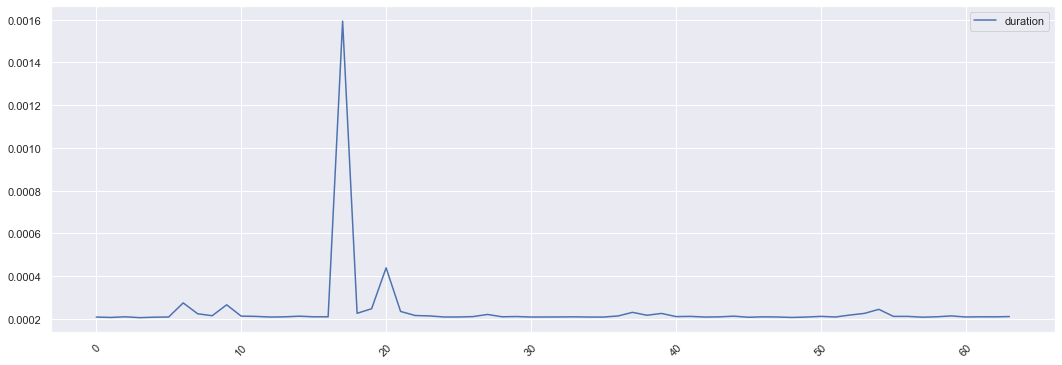

In [113]:
ax = df.plot(figsize=(18,6))
# not mapping strings to duration correctly
plt.xticks(rotation=45)
#ax.set_xticklabels(df.string.to_list())
# lots of dumbness here
# ax.set_xlabel(df.string.to_list())
ax.set_xticks(df.string.to_list())
ax.set_xlabel('string')
ax.set_ylabel('duration')

<AxesSubplot:xlabel='duration', ylabel='Density'>

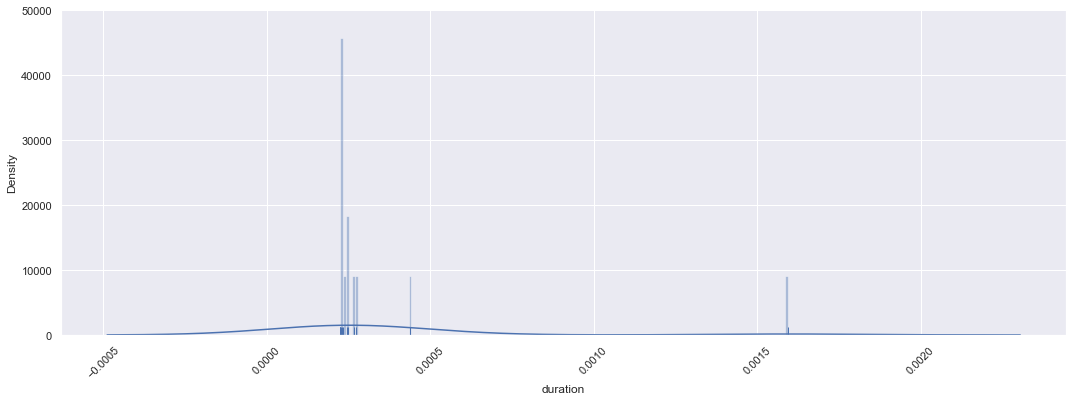

In [87]:
sns.set(rc={'figure.figsize':(18,6)})
plt.xticks(rotation=45)
sns.distplot(df[df['duration']> .000222]['duration'],bins=150, rug=True, kde=True)

## example of brute force strcmp analysis attacks 

Here's a dictionary matcher

In [88]:
# get a built-in dictionary
wordsraw = open('/usr/share/dict/words','r').readlines()
[x.strip('\n') for x in wordsraw]
words = [x.strip('\n') for x in wordsraw]

In [89]:
# set our name as 'apple'
name='apple'
# a longer one
name2 = 'unresourcefulness'

**This takes a long time to run**

In [91]:
stash2 = {}
print(datetime.now())
runstart = attotime.attodatetime.now()
for w in range(0,len(words)):
    start = attotime.attodatetime.now()
    if compare1(words[w], name):
            if compare1(s, name):
                if words[w] == name:
                    print('Name is', words[w])
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash2[s] = str(duration)
                print(s)
                stub = s
                break
    else:
        end = attotime.attodatetime.now()
        duration = end - start
        stash2[s] = str(duration)
        pass
runend = attotime.attodatetime.now()
print(runend - runstart)

2021-07-05 13:50:14.567501
__
0:00:00.0031740665435791


In [ ]:
sorted(stash2.items(),key=lambda x: x[1])[:5]

In [ ]:
compare1('adam',name)

In [ ]:

stash3 = {}
for c in valid_chars:
    stub = c
    for loop in range(0, len(name)):
        stublist = [stub + l for l in valid_chars]
        for s in stublist:
            start = attotime.attodatetime.now()
            if compare1(s, name):
                if s == name:
                    print('Name is', s)
                    break
                else:
                    end = attotime.attodatetime.now()
                    duration = end - start
                    stash3[s] = str(duration)
                    print(s)
                    stub = s
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash3[s] = str(duration)
                pass

In [ ]:
sorted(stash2.items(), key=lambda x: x[1])[-10:]

**and a modified dictionary word**

In [17]:
name='orang00t4_n'
stash4 = {}
for c in valid_chars:
    stub = c
    for loop in range(0, len(name)):
        stublist = [stub + l for l in valid_chars]
        for s in stublist:
            start = attotime.attodatetime.now()
            if compare1(s, name):
                if s == name:
                    print('Name is', s)
                    break
                else:
                    end = attotime.attodatetime.now()
                    duration = end - start
                    stash4[s] = str(duration)
                    print(s)
                    stub = s
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash4[s] = str(duration)
                pass
            
sorted(stash4.items(), key=lambda x: x[1])[-10:]

or
ora
oran
orang
orang0
orang00
orang00t
orang00t4
orang00t4_
Name is orang00t4_n
Name is orang00t4_n


[('orang00t4_a', '0:00:00.01315021514892578'),
 ('orang00t4_e', '0:00:00.01316189765930176'),
 ('orang00t4_m', '0:00:00.01348590850830078'),
 ('orang00t4_g', '0:00:00.01363611221313477'),
 ('orang00t4_h', '0:00:00.01377582550048828'),
 ('orang00t4_j', '0:00:00.01377701759338379'),
 ('orang00t4_k', '0:00:00.01378893852233887'),
 ('orang00t4_', '0:00:00.01381397247314453'),
 ('orang00t4_i', '0:00:00.01392793655395508'),
 ('orang00t4_l', '0:00:00.01408505439758301')]